### Importing Libraries

Here, we import the main Python libraries we’ll use for data analysis, visualization, and modeling.  
These include tools for working with data, making plots, checking statistics, and building a basic prediction model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.getcwd()
from scipy import stats
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score




In [ ]:
df_sierra = pd.read_csv('../data/sierraleone-bumbuna.csv')
display(df_sierra.head())
df_sierra.info()


SyntaxError: invalid syntax (2876533778.py, line 1)

In [ ]:
print(df_sierra.columns)

Index(['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS',
       'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation',
       'TModA', 'TModB', 'Comments'],
      dtype='object')


Timestamp Formatting and Indexing
We convert the 'Timestamp' column to a proper datetime format using pandas.
This column is then set as the index of the DataFrame to allow for time series operations.
Finally, we sort the index to ensure chronological ordering.

In [ ]:
df_sierra['Timestamp'] = pd.to_datetime(df_sierra['Timestamp'])
df_sierra.set_index('Timestamp', inplace=True)
df_sierra.sort_index(inplace=True)


## Profiling Sierra Leone Dataset 
After setting the datetime index, we generate a concise summary of the dataset with info(), numerical descriptive statistics with describe(), counts of unique values per column with nunique(), and missing values count per column with isnull().sum(). This gives a solid understanding of data quality and structure before cleaning.

In [ ]:
print(df_sierra.info())
print(df_sierra.describe())
print(df_sierra.nunique())
print(df_sierra.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2021-10-30 00:01:00 to 2022-10-30 00:00:00
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   GHI            525600 non-null  float64
 1   DNI            525600 non-null  float64
 2   DHI            525600 non-null  float64
 3   ModA           525600 non-null  float64
 4   ModB           525600 non-null  float64
 5   Tamb           525600 non-null  float64
 6   RH             525600 non-null  float64
 7   WS             525600 non-null  float64
 8   WSgust         525600 non-null  float64
 9   WSstdev        525600 non-null  float64
 10  WD             525600 non-null  float64
 11  WDstdev        525600 non-null  float64
 12  BP             525600 non-null  int64  
 13  Cleaning       525600 non-null  int64  
 14  Precipitation  525600 non-null  float64
 15  TModA          525600 non-null  float64
 16  TModB          525600 non-null  float64


In [ ]:
df_sierra.drop(columns=['Comments'], inplace=True)

## Replace Negative Values with NaN for Solar Radiation Columns

In [ ]:
solar_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']

for col in solar_cols:
    df_sierra.loc[df_sierra[col] < 0, col] = pd.NA


## Check Missing Data After Replacement

In [ ]:
df_sierra[solar_cols].isna().sum()


GHI     261135
DNI     266352
DHI     263128
ModA         0
ModB         0
dtype: int64

## Impute Missing GHI, DNI, DHI Using Forward Fill

In [ ]:
df_sierra[['GHI', 'DNI', 'DHI']] = df_sierra[['GHI', 'DNI', 'DHI']].ffill()


In [ ]:
df_sierra[['GHI', 'DNI', 'DHI']] = df_sierra[['GHI', 'DNI', 'DHI']].ffill().bfill()
df_sierra[['GHI', 'DNI', 'DHI']].isna().sum()


GHI    0
DNI    0
DHI    0
dtype: int64

In [ ]:
duplicates = df_sierra.duplicated().sum()
duplicates_timestamps = df_sierra.index.duplicated().sum()
print(f"Duplicated rows: {duplicates}")
print(f"Duplicated timestamps: {duplicates_timestamps}")


Duplicated rows: 39871
Duplicated timestamps: 0


In [ ]:
df_sierra = df_sierra.drop_duplicates()
print(f"New shape after removing duplicates: {df_sierra.shape}")


New shape after removing duplicates: (485729, 17)


In [ ]:
outliers_ws = df_sierra[df_sierra['WS'] < 0].shape[0]
outliers_tamb = df_sierra[(df_sierra['Tamb'] < -50) | (df_sierra['Tamb'] > 60)].shape[0]
outliers_rh = df_sierra[(df_sierra['RH'] < 0) | (df_sierra['RH'] > 100)].shape[0]

print(f"Negative wind speed count: {outliers_ws}")
print(f"Temperature outliers count: {outliers_tamb}")
print(f"Humidity outliers count: {outliers_rh}")


Negative wind speed count: 0
Temperature outliers count: 0
Humidity outliers count: 0


In [ ]:
precip_with_high_ghi = df_sierra[(df_sierra['Precipitation'] > 0) & (df_sierra['GHI'] > 50)].shape[0]
print(f"Rows with precipitation > 0 but GHI > 50: {precip_with_high_ghi}")


Rows with precipitation > 0 but GHI > 50: 1620


In [ ]:
print("Unique Cleaning values:", df_sierra['Cleaning'].unique())
print("Unique BP values:", df_sierra['BP'].unique())


Unique Cleaning values: [0 1]
Unique BP values: [1002 1001 1003 1000 1004 1005 1006  999  998  997  996  995  994  993]


In [ ]:
df_sierra['Cleaning'].value_counts()
df_sierra['BP'].value_counts()


BP
1000    96787
1001    83239
999     81454
1002    59005
998     51175
997     33088
1003    30431
996     21659
1004    11890
995     10886
994      3276
1005     1841
993       977
1006       21
Name: count, dtype: int64

In [ ]:
print(df_sierra['Cleaning'].value_counts())


Cleaning
0    485221
1       508
Name: count, dtype: int64


In [ ]:
print(df_sierra.isna().sum())
print(df_sierra['Precipitation'].value_counts())
print(df_sierra.columns)



GHI              0
DNI              0
DHI              0
ModA             0
ModB             0
Tamb             0
RH               0
WS               0
WSgust           0
WSstdev          0
WD               0
WDstdev          0
BP               0
Cleaning         0
Precipitation    0
TModA            0
TModB            0
dtype: int64
Precipitation
0.0    474372
0.1      7436
0.2      1485
0.3       745
0.4       439
0.5       309
0.6       242
0.7       172
0.8       136
0.9       102
1.1        61
1.0        60
1.2        45
1.3        40
1.4        23
1.6        20
1.5        13
1.7        11
1.9         6
1.8         5
2.0         3
2.4         2
2.1         1
2.3         1
Name: count, dtype: int64
Index(['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust',
       'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA',
       'TModB'],
      dtype='object')


## Data Visualization
Now that the data is clean, let’s start by looking at some basic plots to understand the key variables like solar radiation and weather conditions. This will help us see patterns and trends in the data.

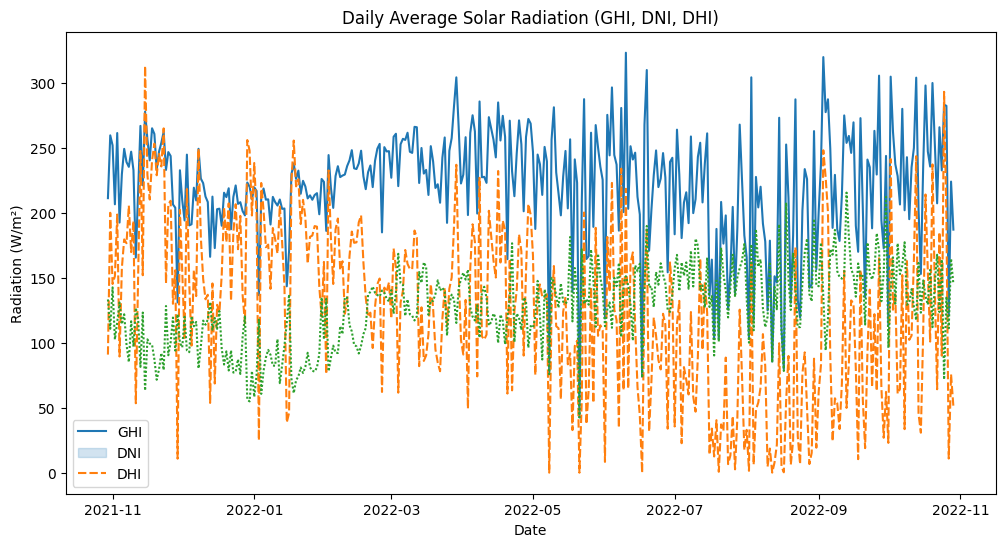

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_sierra[['GHI', 'DNI', 'DHI']].resample('D').mean())
plt.title('Daily Average Solar Radiation (GHI, DNI, DHI)')
plt.xlabel('Date')
plt.ylabel('Radiation (W/m²)')
plt.legend(['GHI', 'DNI', 'DHI'])
plt.show()

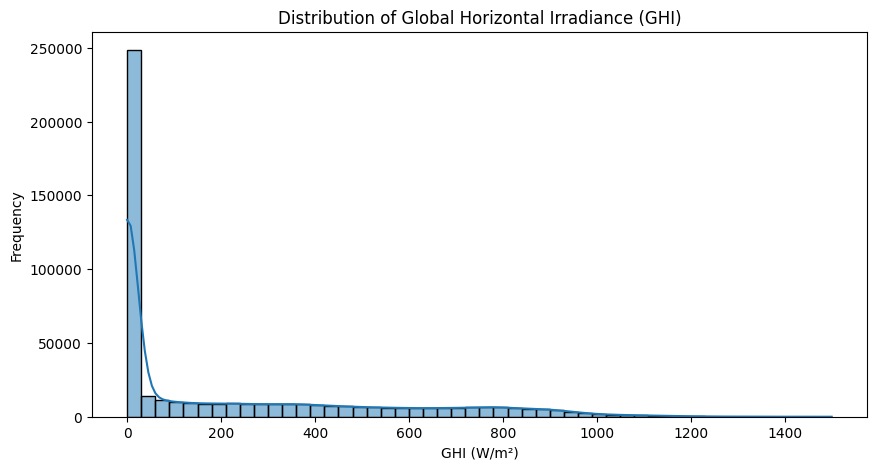

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df_sierra['GHI'], bins=50, kde=True)
plt.title('Distribution of Global Horizontal Irradiance (GHI)')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Frequency')
plt.show()


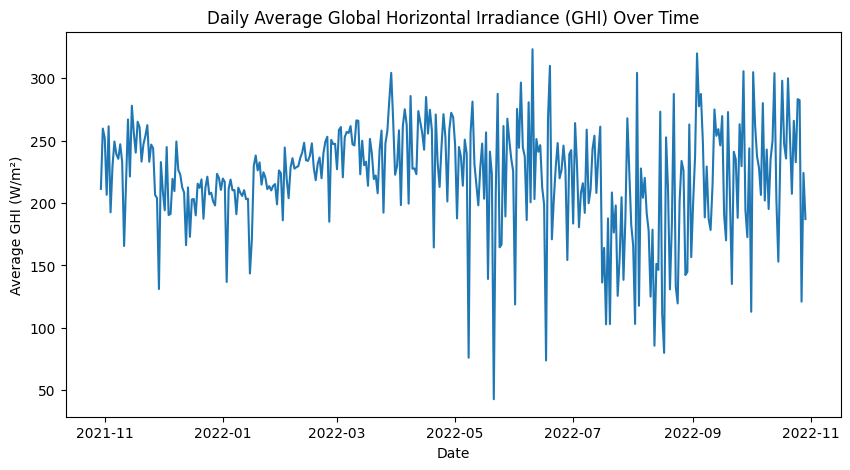

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_sierra['GHI'].resample('D').mean())
plt.title('Daily Average Global Horizontal Irradiance (GHI) Over Time')
plt.xlabel('Date')
plt.ylabel('Average GHI (W/m²)')
plt.show()


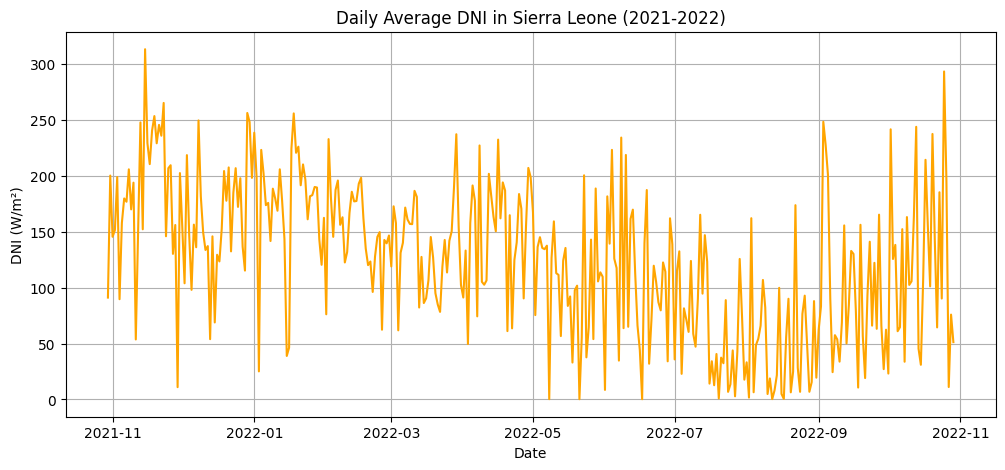

In [ ]:
dni_daily = df_sierra['DNI'].resample('D').mean()

plt.figure(figsize=(12,5))
plt.plot(dni_daily.index, dni_daily, color='orange')
plt.title('Daily Average DNI in Sierra Leone (2021-2022)')
plt.xlabel('Date')
plt.ylabel('DNI (W/m²)')
plt.grid(True)
plt.show()


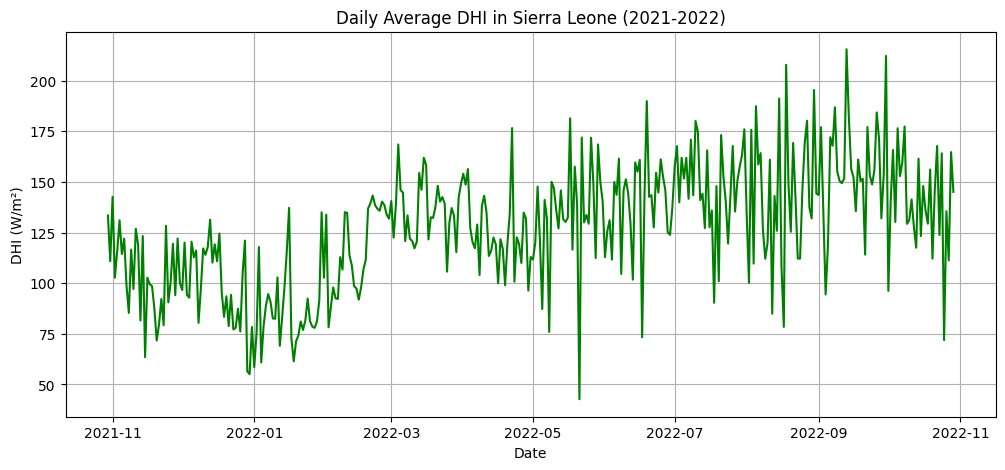

In [ ]:
dhi_daily = df_sierra['DHI'].resample('D').mean()

plt.figure(figsize=(12,5))
plt.plot(dhi_daily.index, dhi_daily, color='green')
plt.title('Daily Average DHI in Sierra Leone (2021-2022)')
plt.xlabel('Date')
plt.ylabel('DHI (W/m²)')
plt.grid(True)
plt.show()


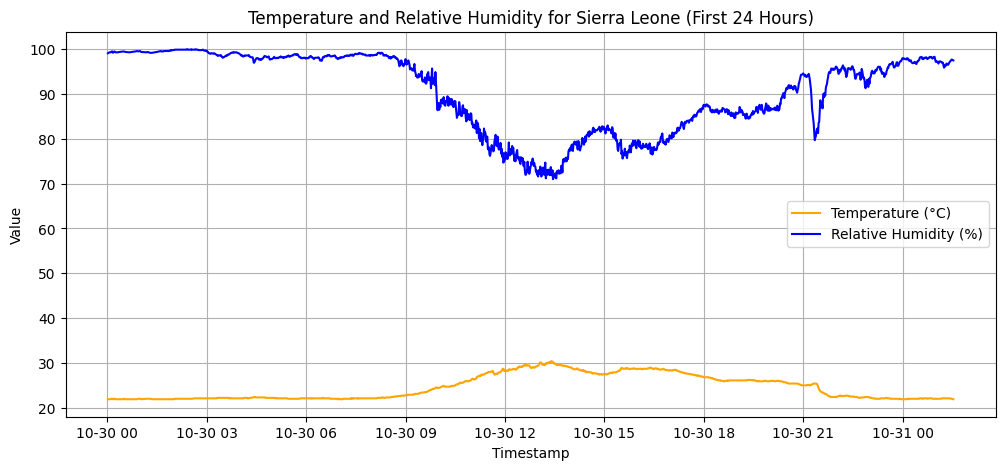

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_sierra.index[:1440], df_sierra['Tamb'][:1440], label='Temperature (°C)', color='orange')
plt.plot(df_sierra.index[:1440], df_sierra['RH'][:1440], label='Relative Humidity (%)', color='blue')
plt.title('Temperature and Relative Humidity for Sierra Leone (First 24 Hours)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

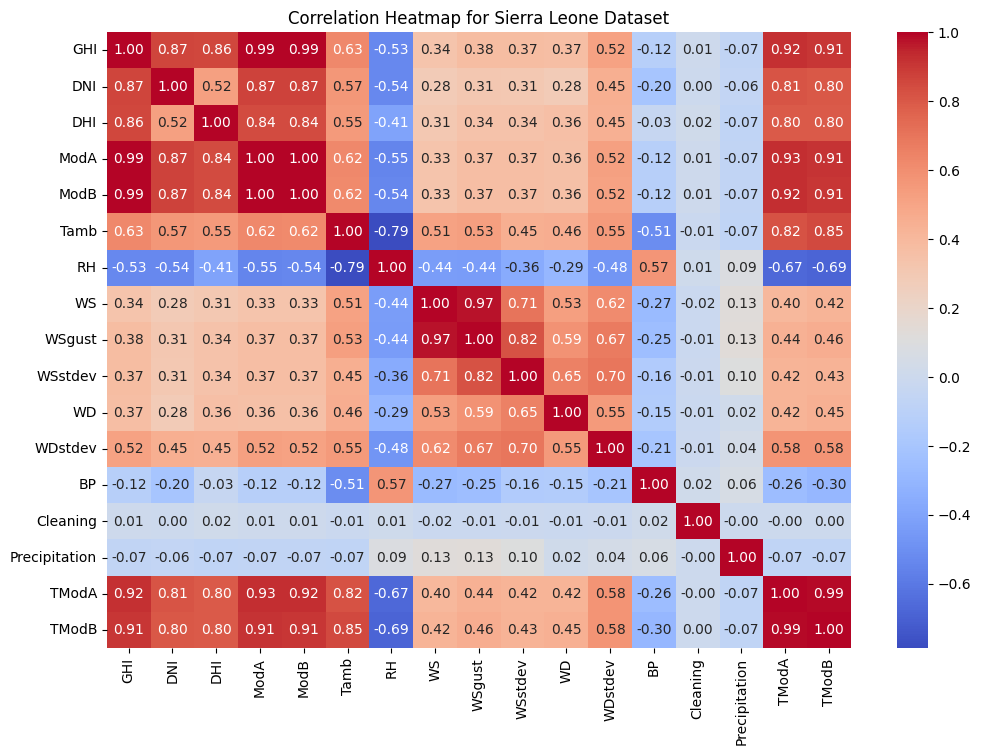

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_sierra.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap for Sierra Leone Dataset")
plt.show()

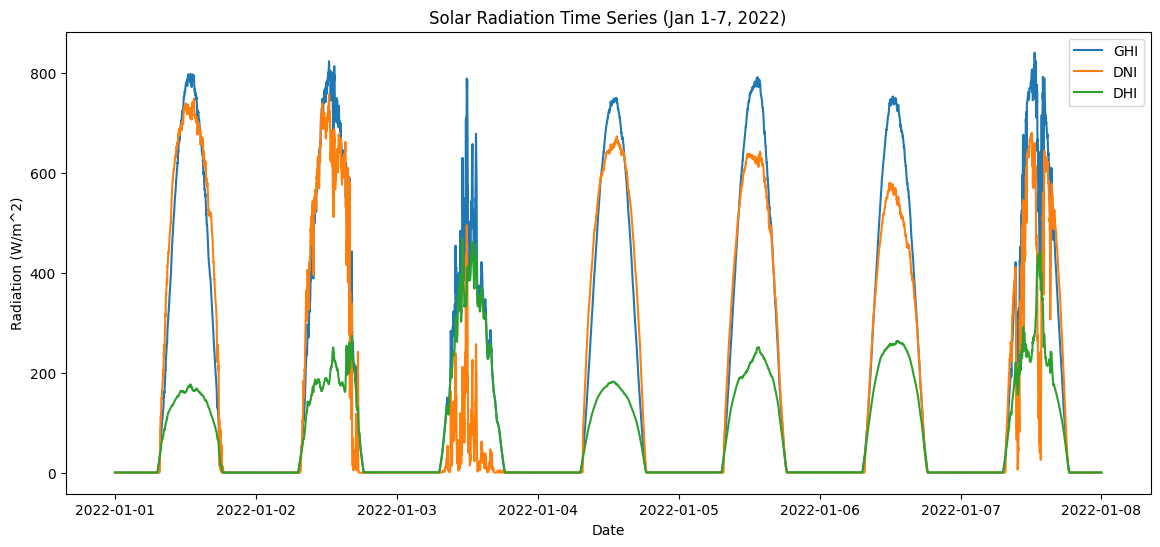

In [ ]:
sample_period = df_sierra['2022-01-01':'2022-01-07']

plt.figure(figsize=(14,6))
plt.plot(sample_period.index, sample_period['GHI'], label='GHI')
plt.plot(sample_period.index, sample_period['DNI'], label='DNI')
plt.plot(sample_period.index, sample_period['DHI'], label='DHI')
plt.xlabel('Date')
plt.ylabel('Radiation (W/m^2)')
plt.title('Solar Radiation Time Series (Jan 1-7, 2022)')
plt.legend()
plt.show()


In [ ]:
df_sierra = df_sierra.copy()
df_sierra['month'] = df_sierra.index.month


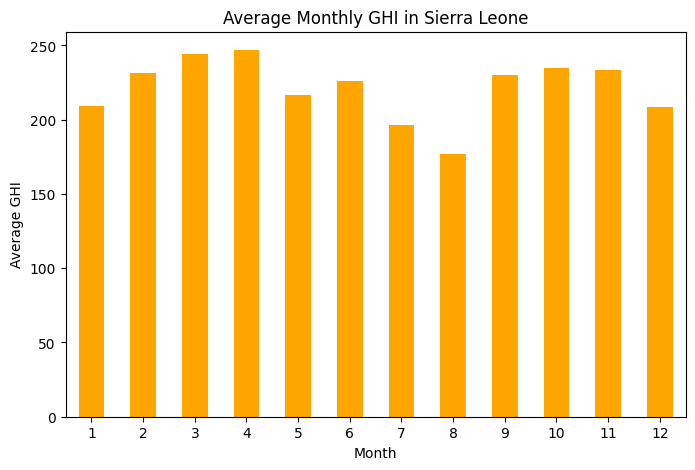

In [ ]:
monthly_ghi = df_sierra.groupby('month')['GHI'].mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
monthly_ghi.plot(kind='bar', color='orange')
plt.title('Average Monthly GHI in Sierra Leone')
plt.xlabel('Month')
plt.ylabel('Average GHI')
plt.xticks(rotation=0)
plt.show()


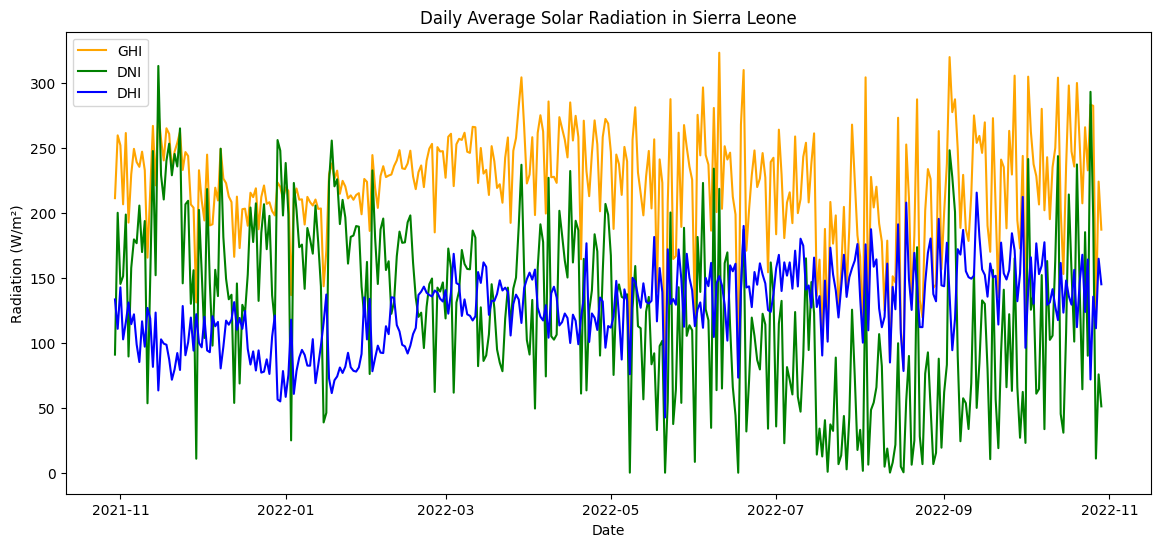

In [ ]:
daily_avg = df_sierra.resample('D').mean()[['GHI', 'DNI', 'DHI']]

plt.figure(figsize=(14,6))
plt.plot(daily_avg.index, daily_avg['GHI'], label='GHI', color='orange')
plt.plot(daily_avg.index, daily_avg['DNI'], label='DNI', color='green')
plt.plot(daily_avg.index, daily_avg['DHI'], label='DHI', color='blue')
plt.title('Daily Average Solar Radiation in Sierra Leone')
plt.xlabel('Date')
plt.ylabel('Radiation (W/m²)')
plt.legend()
plt.show()


In [1]:
df_sierra.to_csv('sierra_leone_cleaned.csv', index=False)

NameError: name 'df_sierra' is not defined